<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/CP%20CPMG%20UDD%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 45.1 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#6. Pulse Shaping

### 1) Single $ \pi $ Envelope

In [455]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

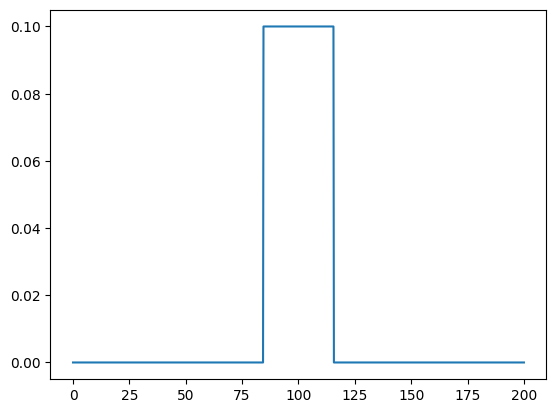

In [456]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Square(tlist, {'A': 0.1}, 100))

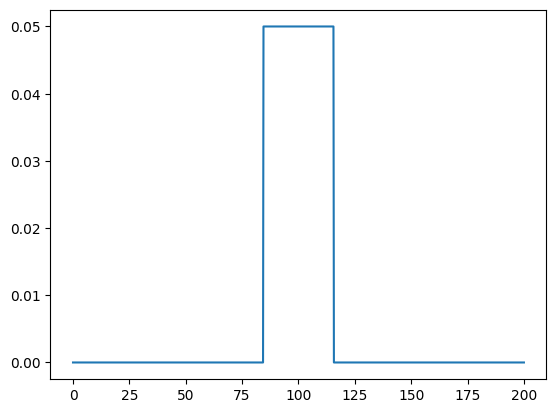

In [457]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Square(tlist, {'A': 0.1}, 100))

In [458]:
# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

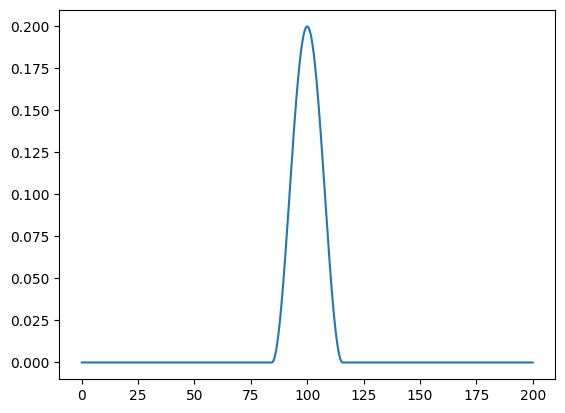

In [459]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Cosine(tlist, {'A': 0.1}, 100))

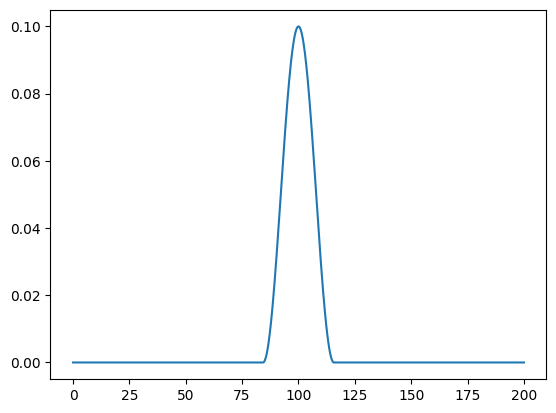

In [460]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Cosine(tlist, {'A': 0.1}, 100))

In [461]:
# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

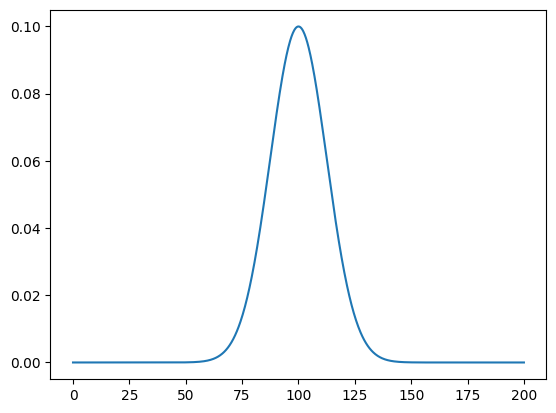

In [462]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Pi_Gaussian(tlist, {'A': 0.1}, 100))

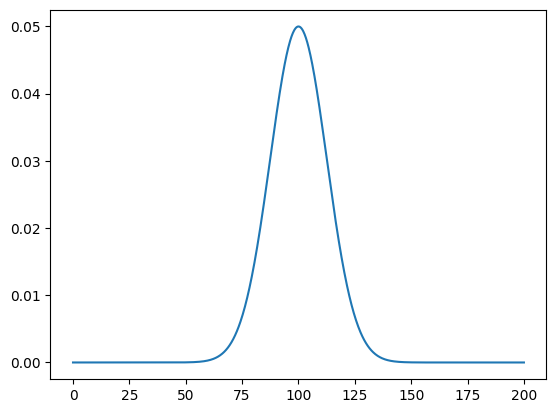

In [463]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Half_Pi_Gaussian(tlist, {'A': 0.1}, 100))

### 2) Single $ \pi $ Pulse

In [464]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

In [465]:
# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

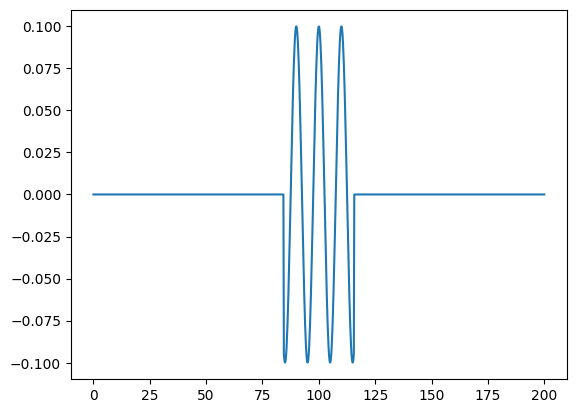

In [466]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(0, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

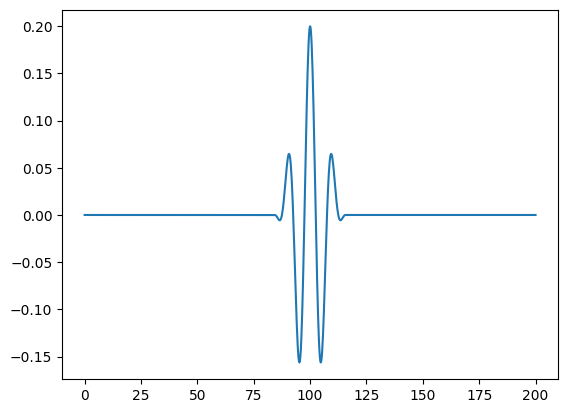

In [467]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(1, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

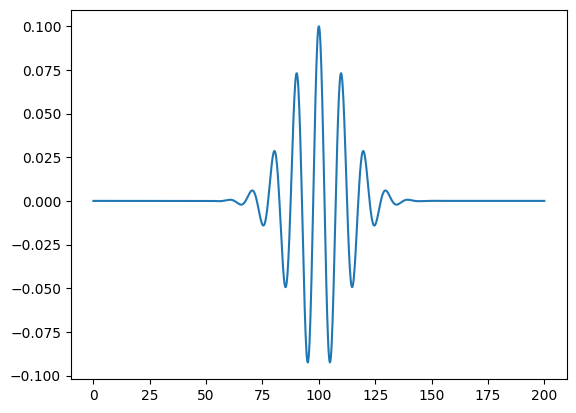

In [468]:
tlist = np.linspace(0, 200, 1000)
plt.figure()
plt.plot(tlist, Hrd_rot(Hrd_env(2, 1), tlist, {'A': 0.1, 'Omega_rd': 2*np.pi*0.1, 'Phi': 0}, 100))

### 3) Pulse Shaping Function

In [469]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [470]:
Pulse_Timing(0, 200, 10, 0)

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190.])

In [471]:
Pulse_Timing(100, 300, 10, 2)

array([106.81483474, 119.9800845 , 138.59855926, 161.40144074,
       186.83475024, 213.16524976, 238.59855926, 261.40144074,
       280.0199155 , 293.18516526])

In [472]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    # CPMG
    elif (Func==1) :

      pulse = Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    # UDD
    elif (Func==2) :

      pulse = Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), tlist, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [473]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(tlist, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(tlist, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(tlist, {'A': A}, T_end)

    return pulse

### 4) Visualize Ramsey & Spin Echo Pulse (Lab Frame)

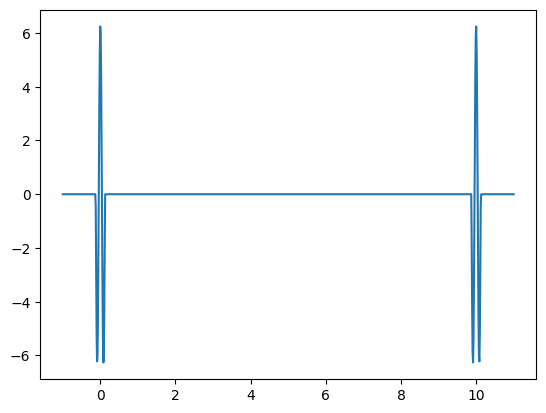

In [474]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

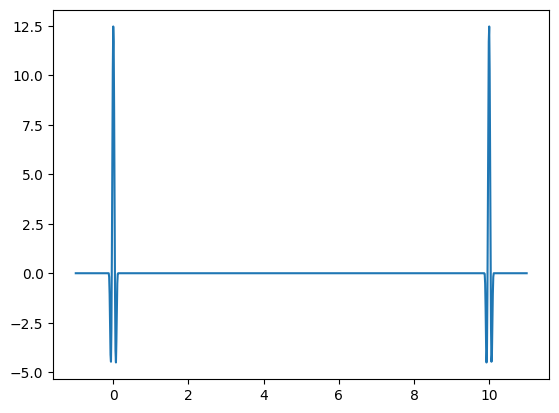

In [475]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

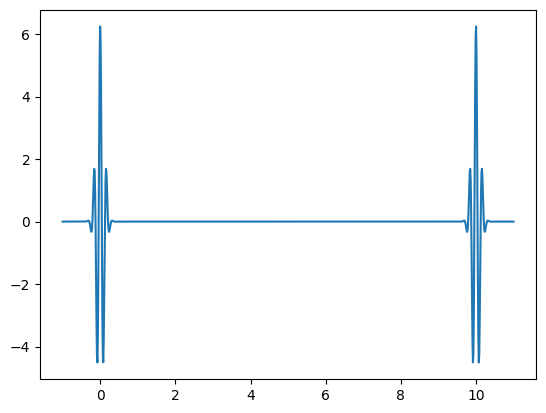

In [476]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

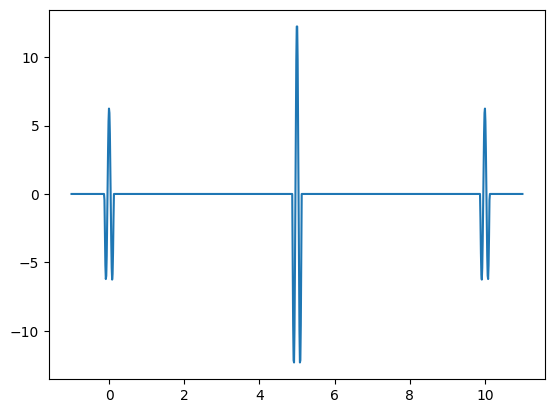

In [477]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

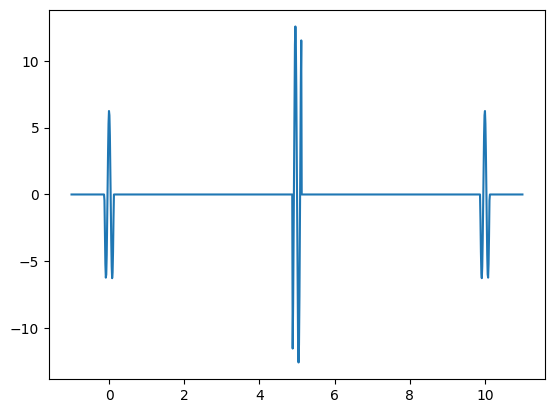

In [478]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 5) Visualize CP Pulse (Lab Frame)

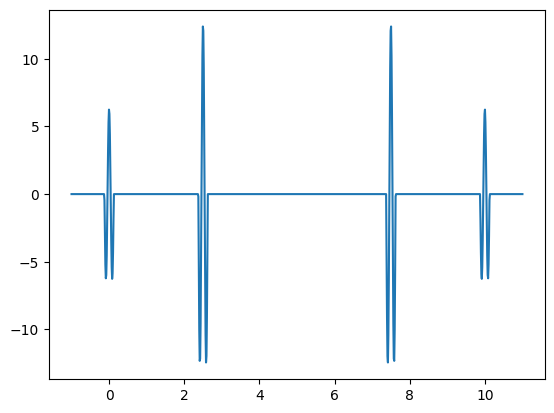

In [479]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

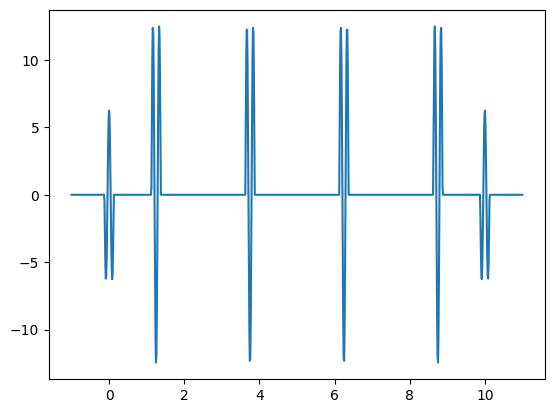

In [480]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

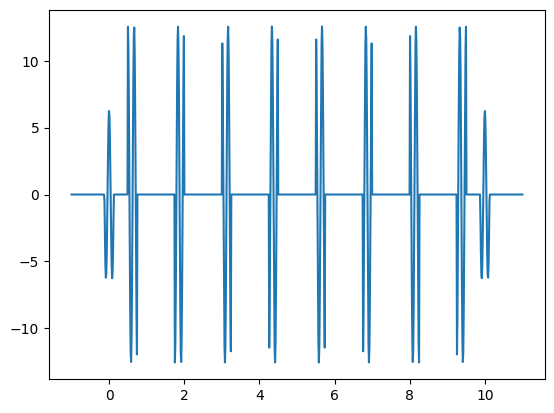

In [481]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 6) Visualize CPMG Pulse (Lab Frame)

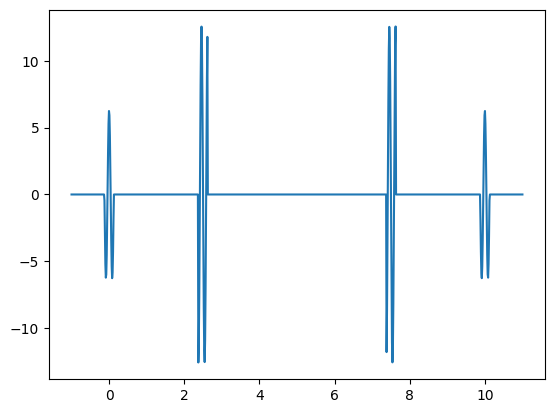

In [482]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

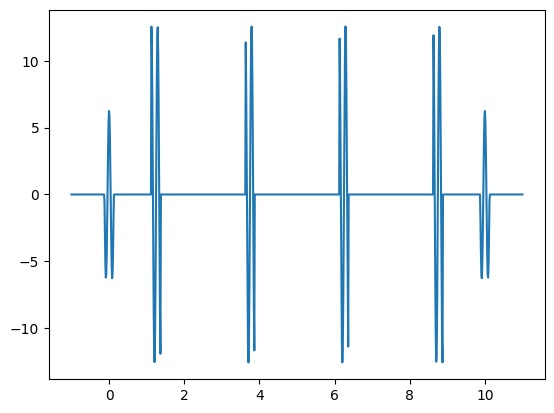

In [483]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

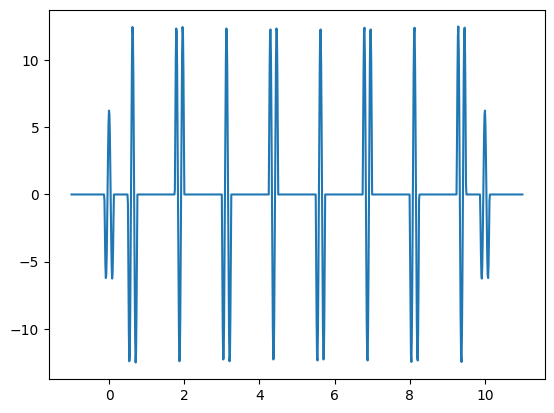

In [484]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 7) Visualize UDD Pulse (Lab Frame)

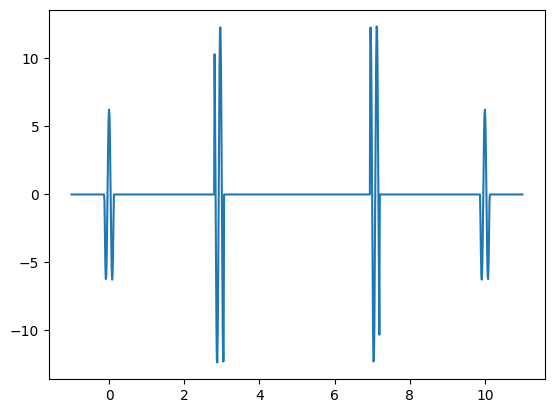

In [485]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

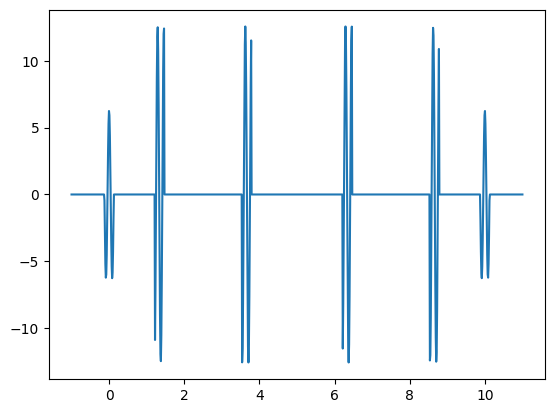

In [486]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

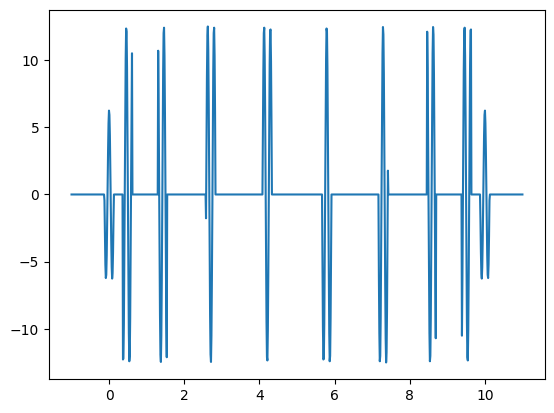

In [487]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 8) Visualize Ramsey & Spin Echo Pulse (Rotating Frame)

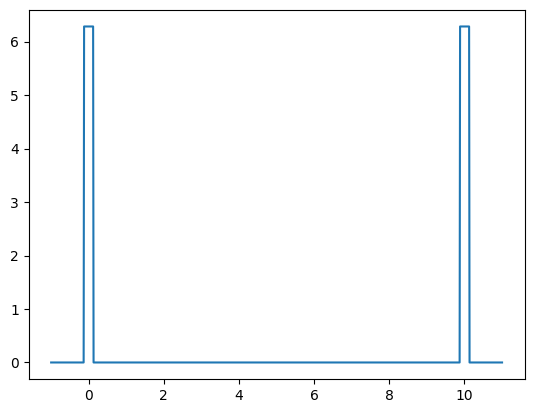

In [488]:
# Ramsey
# Square Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0}))

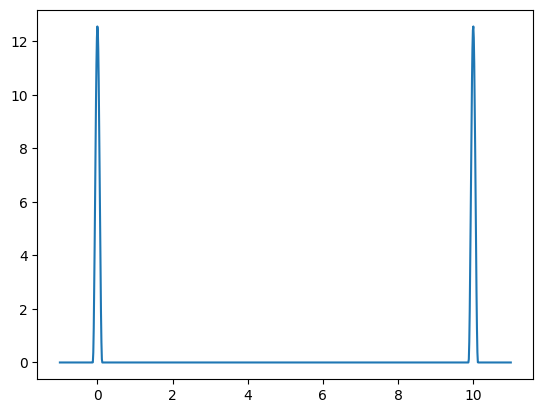

In [489]:
# Ramsey
# Cosine Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 1, 'Func': 0}))

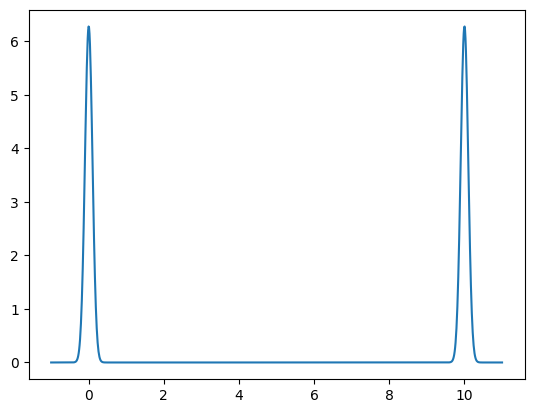

In [490]:
# Ramsey
# Gaussian Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 2, 'Func': 0}))

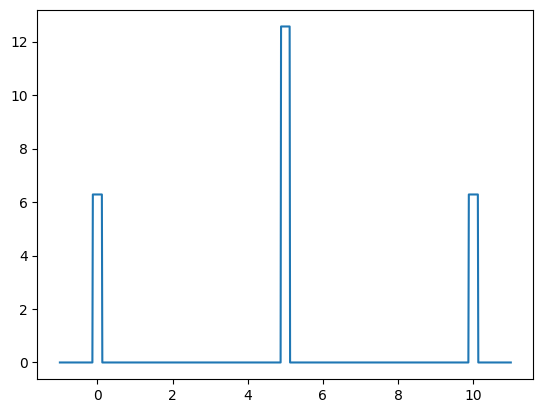

In [491]:
# Spin Echo
# Square Pulse
# X Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 0}))

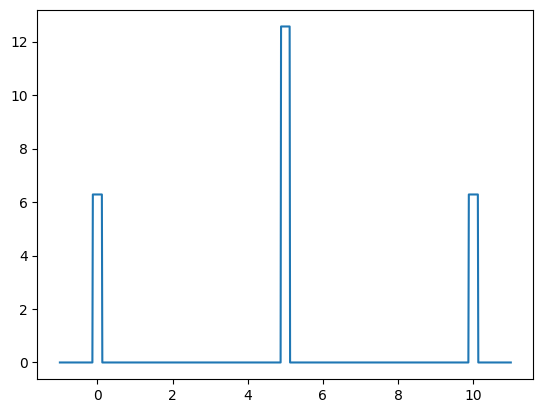

In [492]:
# Spin Echo
# Square Pulse
# Y Pi Pulse

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 1, 'Env': 0, 'Func': 1}))

### 9) Visualize CP Pulse (Rotating Frame)

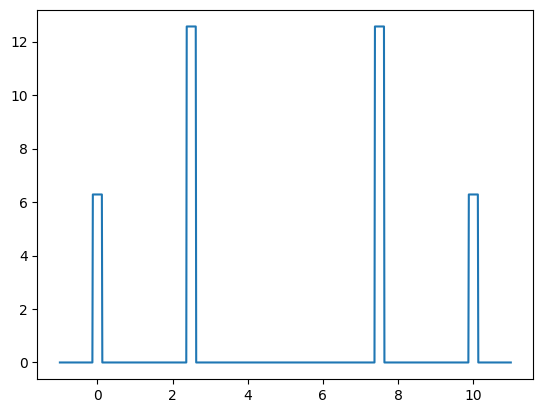

In [493]:
# CP
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 0}))

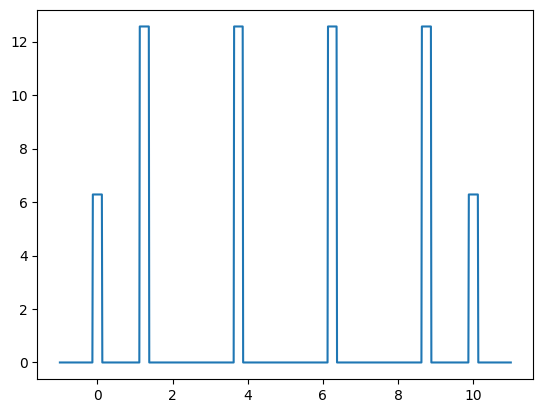

In [494]:
# CP
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 0}))

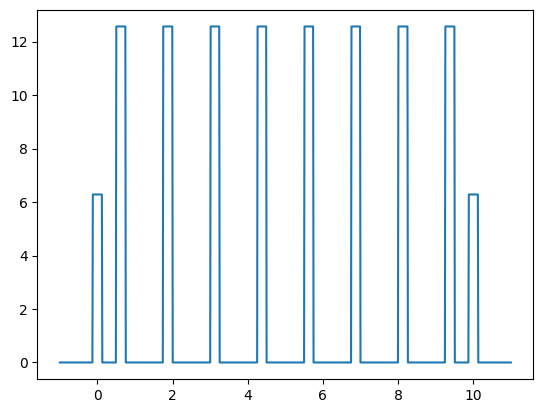

In [495]:
# CP
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 0}))

### 10) Visualize CPMG Pulse (Rotating Frame)

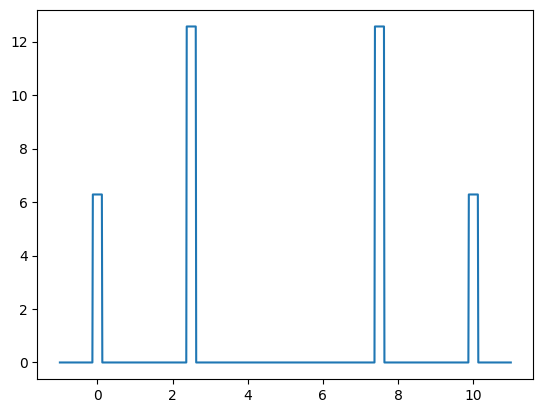

In [496]:
# CPMG
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 1}))

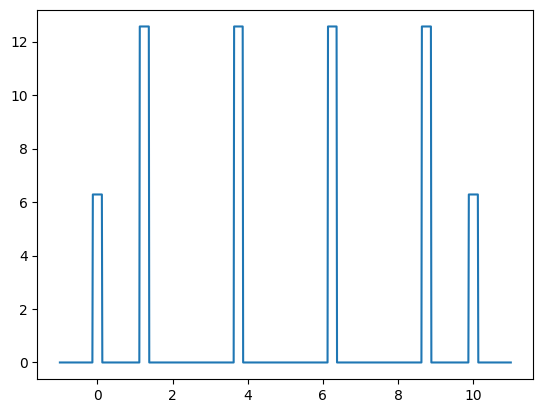

In [497]:
# CPMG
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 1}))

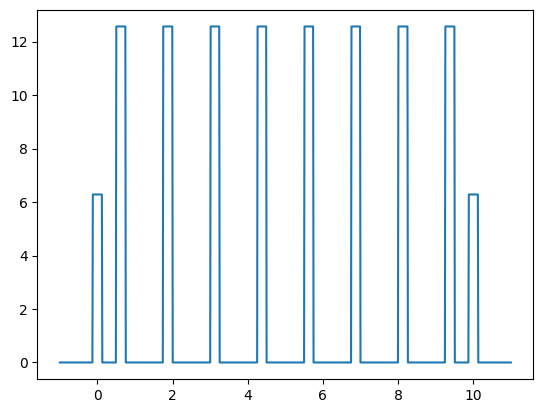

In [498]:
# CPMG
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 1}))

### 11) Visualize UDD Pulse (Rotating Frame)

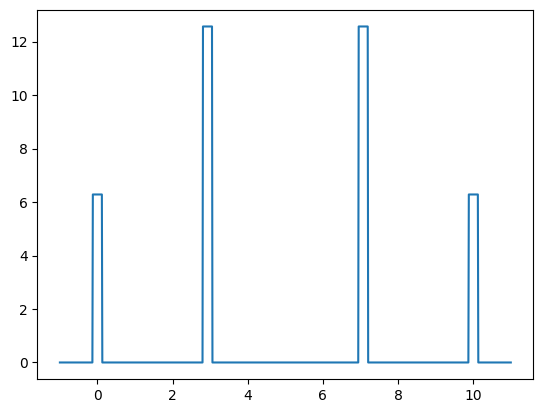

In [499]:
# UDD
# N=2

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 2, 'Env': 0, 'Func': 2}))

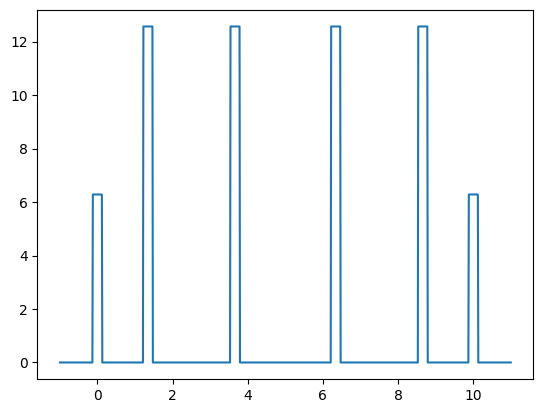

In [500]:
# UDD
# N=4

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 4, 'Env': 0, 'Func': 2}))

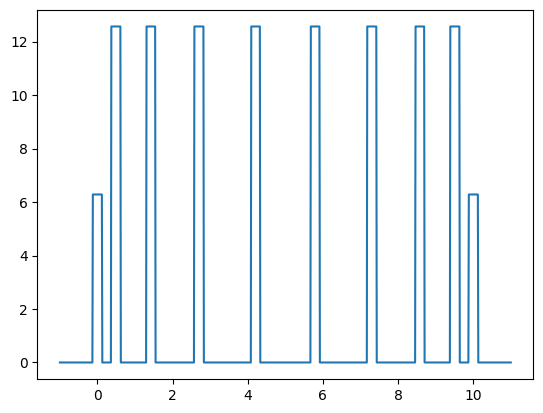

In [501]:
# UDD
# N=8

tlist = np.linspace(-1, 11, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*2, 'Omega_rd': 2 * np.pi * 6.0, 'T_srt': 0, 'T_end': 10, 'N': 8, 'Env': 0, 'Func': 2}))

### 12) Qubit not coupled with Resonator (Lab Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [530]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

In [531]:
# operator

tlist = np.linspace(-1,11,10000)

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

In [532]:
# time-dependent coefficient for drive
def Hrd_ddd(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T_end'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['0mega_rd']
    return Hrd_ddd(t, args) * np.cos(omega_rd * t)

In [533]:
result0 = mesolve(
    [H0, [sx, Hrd_coeff]],
    basis(2,0),
    tlist,
    args = {'A': 2*np.pi*2, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10, 'N': 0, 'Env': 0, 'Func': 0},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

KeyError: '0mega_rd'

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()